In [2]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import distributions
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
sns.set_style('whitegrid')
sns.set_context('poster')

In [8]:
tumordata = pd.read_table('rattumour.txt', header=0, sep='\s+')

In [20]:
tumory = tumordata.y[:-1].values
tumorn = tumordata.N[:-1].values

In the 71st experiment, we are told that 4 out of 14 rats develop tumors. Our problem is to estimate the risk of tumor in the rats in the 71st experiment.

Thus we are considering the problem of estimating the tumor rate from a small experiment (no 71) and a prior constructed from previous experiments with similar structure. Mathematically, we consider the current and historical experiments as random samples from a common population.

In [25]:
tumor_rat = [e[0]/e[1] for e in zip(tumory, tumorn)]
tmean = np.mean(tumor_rat)
tvar = np.var(tumor_rat)
tmean, tvar

(0.13600653889043893, 0.010557640623609196)

(array([14.,  8., 14.,  3.,  3., 13.,  6.,  2.,  6.,  1.]),
 array([0.    , 0.0375, 0.075 , 0.1125, 0.15  , 0.1875, 0.225 , 0.2625,
        0.3   , 0.3375, 0.375 ]),
 <a list of 10 Patch objects>)

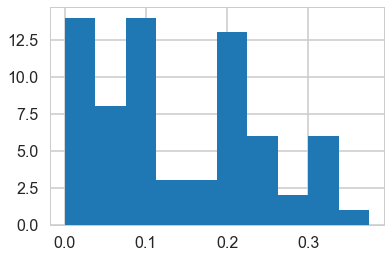

In [26]:
plt.hist(tumor_rat)

# Modeling

Since a rat is either have or don't have the tumor, it makes sense to use a Binomial model for **each** experiment, assumming a sample size $n_j$ and a probability $\theta_j$ that a rat has a tumor. For any one of the experiments, we have the likelihood: $$p(y_i|\theta_i, n_i) = Binom(n_i, y_i, \theta_i)$$

Then for all the experiment we have the likelihood: $$p(Y|\Theta, \{n_i\}) = \prod_{i=1}^{70}Binom(n_i, y_i, \theta_i)$$

### Picking prior $p(\Theta)$

### No pooling

Our first thought is to use Beta (conjugate prior to Binomial) for each $\theta_i$:

$$\begin{align}\theta_i &\sim Beta(\alpha_i, \beta_i)\\
p(\Theta|\{\alpha_i\},\{\beta_i\}) &= \prod_{i=1}^{70}Beta(\theta_i, \alpha_i, \beta_i)
\end{align}$$

where $\alpha_i$ and $\beta_i$ are **hyperparameters**.

These will leads to a very overfit models with 210 parameters and not much data. This model will have a large amount of variance, i.e, it is sensitive to outliers.

### Full pooling
The other extreme is to assume that there is only one $\theta$ in the problem, and set an prior on it, making this a three parameter problem. This ignores any variation amongst the sampling units other than sampling variance. Thus such a model might thus be underfit, unable to capture the variations in the samples. This is likely a model with a large amount of bias.

### Partial pooling 

We compromise and assume that each $\theta_i$ are drawn from a population distribution given by a conjugate Beta prior $Beta(\alpha, \beta)$ with parameters $\alpha$ and $\beta$ to describe this data.

$$\begin{align}\theta_i &\sim Beta(\alpha, \beta)\\
p(\Theta| \alpha, \beta) &= \prod_{i=1}^{70}Beta(\theta_i, \alpha, \beta)
\end{align}$$

The structure of this model is shown as follows: ![](./rat-tumor-hier2.png)

Models such as the one above are called **hierarchical model**, with observable outcomes ($Y_i$) modeled conditionally on certain parameters ($\theta_i)$, which themselves are given a probabilistic specification in terms of hyperparameters.

Modeling in this way has two advantages:

1. It helps us develop a computational strategy to solve the problem

2. It allows estimates of the probabilities of any one of the units (here, one of the experiments) to borrow strength from all the data as a whole through the estimation of the hyperparameters. In other words, if some of the experiments had lower sample sizes or other outlier like behavior, the procedure helps “regularize” this.

# Full bayesian treatment

Suppose we have $\phi$ as hyperparameters, $\theta$ as parameters, $y$ as observed data. Then in a full Bayesian treatment, we need to compute:

1. joint posterior density $p(\theta, \phi|y) \propto p(\phi)p(\theta|\phi)p(y|\theta)$
2. conditional posterior density $p(\theta|\phi, y)$
3. $p(\phi \mid y) = \frac{p(\theta, \phi \mid y)}{p(\theta \mid \phi, y)}$, by the conditional probability formula.

Applying these steps to the rat tumors we have.

**Step 1**: $$\begin{align}p(\Theta, \alpha, \beta \mid Y, \{n_i\})&\propto p(\alpha, \beta)p(\Theta|\alpha, \beta)p(y|\Theta, \alpha,\beta)\\&\propto p(\alpha, \beta) \prod_{i=1}^{70}Beta(\theta_i, \alpha, \beta)\prod_{i=1}^{70}Binom(n_i, y_i, \theta_i)\end{align}$$

Note that this is a high dimensional problem: there are 72 parameters (70 $\theta$s and $\alpha , \beta$).

**Step 2**:  The **conditional** posterior distribution for each of the $\theta_i$, given everything else is a Beta distribution itself (remember Beta is conjugate prior to Bionomial).

$p(\theta_i  \vert  y_i, n_i, \alpha, \beta) = Beta(\theta_i, \alpha + y_i, \beta + n_i - y_i)$ 

**Step 3**: For each of $\alpha$ and $\beta$, given everything else, the posterior distributions can be shown to be:

$$p(\alpha  \vert  Y, \Theta ,\beta ) \propto p(\alpha, \beta) \, \left(\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)}\right)^N \prod_{i=1}^{N} \theta_i^{\alpha}$$

$$P(\beta  \vert  Y, \Theta ,\alpha ) \propto p(\alpha, \beta) \, \left(\frac{\Gamma(\alpha + \beta)}{\Gamma(\beta)}\right)^N \prod_{i=1}^{N} (1 - \theta_i)^{\beta}$$

Note: The conditional posteriors do depend on $Y$ and $\{n\}$ via the $\theta$'s. 

### Hyperprior construction

In order to perform full bayesian treatment, we need to specify a hyper-priors, $p(\alpha, \beta)$, on these hyperparameters $(\alpha, \beta)$. Since we do not have any knowledge on the rate of tumors in rat experiments, we may wish to assign an improper prior distribution for the hyperparameters, $(\alpha, \beta)$, we must chec, that the posterior distribution $p(\alpha, \beta \mid y)$ is proper.

See the BDA book (p. 110) for the construction of the hyperpriors.

We select the prior $p(\alpha, \beta) \propto (\alpha + \beta)^{-5/2}$

# Sampling

In [29]:
# number of thetas
numthetas=tumorn.shape[0]
numthetas

70

We peform sampling from conditional posterior distribution of $\alpha$, $\beta$ and $\theta$ using Metropolis-Hastings style sampler.

In [30]:
from scipy.special import gammaln

# prior for the hyperparameters
def log_prior(a, b):
    if a <= 0 or b <=0:
        return -np.inf
    return -2.5*np.log(a + b)

# sampling from conditional posterior for the theta
draw_thetas = lambda a,b: beta.rvs(a+tumory,b+tumorn-tumory, size=numthetas)

# conditional posterior (pdf) for alpha
def log_cond_alpha(a,b, thetas):
    if a <= 0 or b <=0:
        return -np.inf
    return numthetas*(gammaln(a+b) - gammaln(a)) + a*np.sum(np.log(thetas)) + log_prior(a,b)
   
# conditional posterior (pdf) for beta
def log_cond_beta(a,b, thetas):
    if a <= 0 or b <=0:
        return -np.inf
    return numthetas*(gammaln(a+b) - gammaln(b)) + b*np.sum(np.log(1.0 - thetas)) + log_prior(a,b)
  
# using the above pdfs we draw for alpha and beta in MH fashion
def draw_alpha(a,b,thetas,proposal_sd, accepts):
    astar = norm.rvs(a,proposal_sd)  # proposed a new alpha
    num = log_cond_alpha(astar,b, thetas) 
    den = log_cond_alpha(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den): 
        accepted=1
    else:
        accepted=0
    accepts['alpha'] = accepts['alpha'] + accepted
    if accepted:
        return astar
    else:
        return a

def draw_beta(a,b,thetas,proposal_sd, accepts):
    bstar = norm.rvs(b,proposal_sd)
    num = log_cond_beta(a,bstar, thetas)
    den = log_cond_beta(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den):
        accepted=1
    else:
        accepted=0
    accepts['beta'] = accepts['beta'] + accepted
    if accepted:
        return bstar
    else:
        return b

In [32]:
burnin=20000
numtraces=200000
totaltraces=burnin+numtraces

alphas=np.empty(totaltraces)
betas=np.empty(totaltraces)
thetas=np.empty((totaltraces, numthetas))

# these are the step sizes for the proposal distribution
# for our M-H sampling for alpha and beta to be used in Gibbs sampling later
alpha_prop_sd=0.6
beta_prop_sd=3.2

#start positions
alphas[0]=1.
betas[0]=1.
thetas[0,:] = (tumory+0.5)/(tumorn+0.5)

#draw_thetas(alphas[0], betas[0])
accepteds={'alpha':0, 'beta':0}

In [33]:
start = time.clock()

In [34]:
for m in np.arange(1,totaltraces):
    alphas[m] = draw_alpha(alphas[m-1],betas[m-1],thetas[m-1,:], alpha_prop_sd, accepteds)
    betas[m] = draw_beta(alphas[m],betas[m-1],thetas[m-1,:], beta_prop_sd, accepteds)
    thetas[m,:] = draw_thetas(alphas[m],betas[m])

In [35]:
accepteds['alpha']/numtraces, accepteds['beta']/numtraces

(0.36043, 0.430705)

In [36]:
#remove burnin samples and thin
thin=40
alphatrace=alphas[burnin+1:totaltraces:thin]
betatrace=betas[burnin+1:totaltraces:thin]
thetastrace=thetas[burnin+1:totaltraces:thin,:]
print(thetastrace.shape, alphatrace.shape)

(5000, 70) (5000,)


Text(0,0.5,'beta')

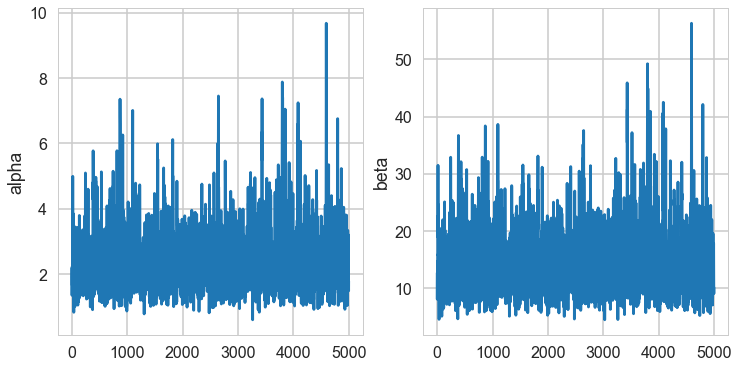

In [37]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(alphatrace)
plt.ylabel('alpha')
plt.subplot(1,2,2)
plt.plot(betatrace)
plt.ylabel('beta')

In [38]:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])

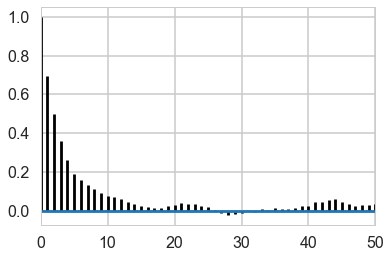

In [39]:
corrplot(alphatrace)


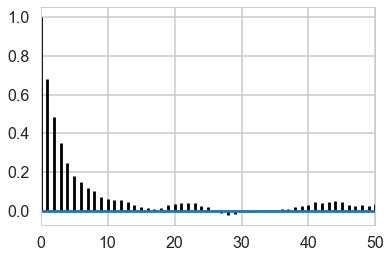

In [40]:
corrplot(betatrace)


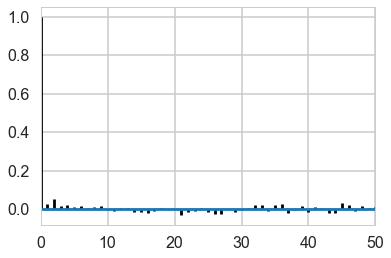

In [41]:
corrplot(thetastrace[:,7])


Text(0,0.5,'p(theta_0 \x0bert  everything)')

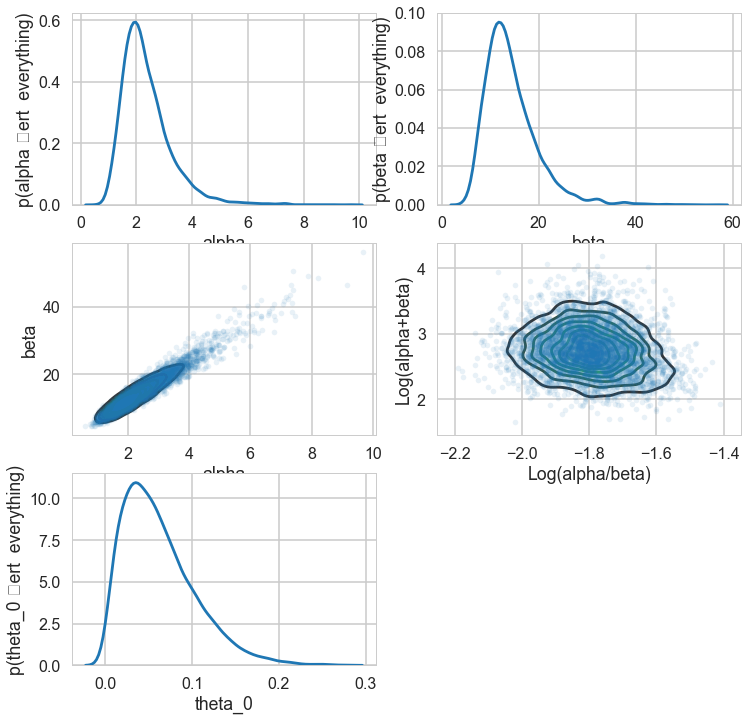

In [50]:
plt.figure(figsize=[12,12])
plt.subplot(3,2,1)
sns.kdeplot(alphatrace)
plt.xlabel('alpha')
plt.ylabel('p(alpha \vert  everything)')
plt.subplot(3,2,2)
sns.kdeplot(betatrace)
plt.xlabel('beta')
plt.ylabel('p(beta \vert  everything)')
plt.subplot(3,2,3)
plt.plot(alphatrace, betatrace,'.', alpha=0.1)
sns.kdeplot(alphatrace, betatrace)
plt.xlabel('alpha')
plt.ylabel('beta')

plt.subplot(3,2,4)
plt.plot(np.log(alphatrace/betatrace), np.log(alphatrace+betatrace),'.', alpha=0.1)
sns.kdeplot(np.log(alphatrace/betatrace), np.log(alphatrace+betatrace))
plt.xlabel('Log(alpha/beta)')
plt.ylabel('Log(alpha+beta)')

plt.subplot(3,2,5)
sns.kdeplot(thetastrace[:,0])
plt.xlabel('theta_0')
plt.ylabel('p(theta_0 \vert  everything)')

In [51]:
percentiles=np.percentile(thetastrace, [2.5,50.0, 97.5], axis=0)
lowerthetas, medianthetas, upperthetas=percentiles

elowertheta = medianthetas - lowerthetas
euppertheta = upperthetas - medianthetas

In [53]:
thetastrace.shape

(5000, 70)

In [44]:
empirical_ratios=tumory/tumorn


(-0.1, 0.5)

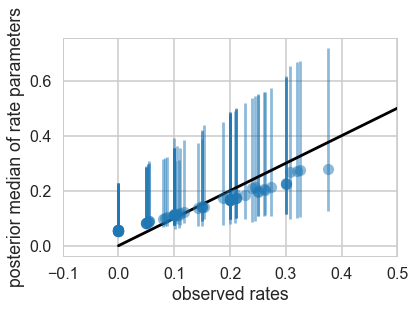

In [45]:
plt.errorbar(empirical_ratios, 
             medianthetas, yerr=[lowerthetas,upperthetas], fmt='o', alpha=0.5)
plt.plot([0,0.5],[0,0.5],'k-')
plt.xlabel("observed rates")
plt.ylabel("posterior median of rate parameters")
plt.xlim(-0.1,0.5)


In [57]:
plt.errorbar(x=[1,2,3], y = )

In [58]:
plt.errorbar?

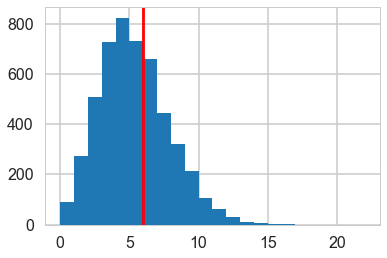

In [46]:
from scipy.stats import binom
pred60 = binom.rvs(tumorn[60],thetastrace[:,60])
plt.hist(pred60, bins=np.arange(tumorn[60]));
plt.axvline(tumory[60],0,1,color='r');

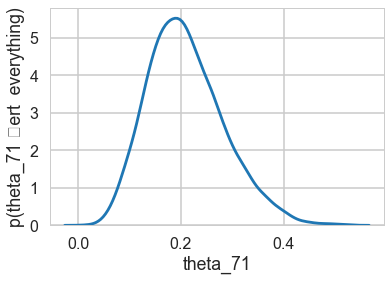

In [47]:
post71 = beta.rvs(alphatrace+4, betatrace+10)
sns.kdeplot(post71)
plt.xlabel('theta_71')
plt.ylabel('p(theta_71 \vert  everything)');

In [48]:
# numpy function falttens by default
percentiles =np.percentile(post71, [2.5,50.0, 97.5])

print("Percentiles: ", percentiles)
print("Naive rate: ", 4.0/14)

Percentiles:  [0.0857767  0.20200502 0.37294876]
Naive rate:  0.2857142857142857
